In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import os
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from skimage import io
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import random

## Cuda


In [2]:
#Controllo che torch sia installato con CUDA abilitato
def check_cuda():
    print(torch.version.cuda)
    cuda_is_ok = torch.cuda.is_available()
    print(f"CUDA Enabled: {cuda_is_ok}")

In [3]:
print(torch.version.cuda)

11.7


## Model parameters


In [50]:
model_weights = True

In [5]:
#Directory per i file di train
DATA_DIR = ''

#Grandezza del Batch (iperparametro)
BATCH_SIZE = 32

#Learning Rate (Iperparametro)
LR = 0.001

#Numero di epoche (Iperparametro)
EPOCHS = 80

DEVICE = 'cuda'

## Dataloader and dataset creation

In [6]:
# Carica il file csv
df_real = pd.read_csv("real_image_dataset_coco.csv")

df_fake = pd.read_csv("fake_image_dataset_biggan.csv")

train_df_real, valid_df_real = train_test_split(df_real, test_size = 0.20, random_state = 42)
train_df_fake, valid_df_fake = train_test_split(df_fake, test_size = 0.20, random_state = 42)

test_df_real = train_df_real.sample(500)
test_df_fake = train_df_fake.sample(500)

train_df_real = train_df_real.drop(test_df_real.index)
train_df_fake = train_df_fake.drop(test_df_fake.index)

train_df = pd.concat([train_df_real, train_df_fake])
valid_df = pd.concat([valid_df_real, valid_df_fake])

test_df = pd.concat([test_df_fake,test_df_real])


# shuffle
train_df= train_df.sample(frac= 1)
valid_df= valid_df.sample(frac= 1)

# Unisci tutti i dataframe in un unico dataframe finale per il train set
final_df = pd.concat([train_df, valid_df])

# Salva il dataframe finale di trian in un file CSV
final_df.to_csv("spectrum_train_dataset.csv", index=False)
df = pd.read_csv("spectrum_train_dataset.csv")


# Crea una lista combinata con 500 immagini false seguite da 500 immagini reali
combined_images = test_df["Anchor"]

# Crea il dataframe del test set con una sola colonna
#test_df = pd.DataFrame(combined_images, columns=[''])

# Salva il dataframe del test set in un file CSV
#test_df.to_csv("test_set.csv", index=False, header=False)

print('Size of train set:', len(train_df))
print('Size of valid set:', len(valid_df))
print('Size of test set:', len(test_df))

Size of train set: 15000
Size of valid set: 4000
Size of test set: 1000


In [7]:
# Carico le immagini del file CSV che ho fornito, per settarle in modo corretto e darle in input alla rete neurale
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor, as_gray= True)
    P_img = io.imread(DATA_DIR + row.Positive, as_gray= True)
    N_img = io.imread(DATA_DIR + row.Negative, as_gray= True)

    
    # Aggiungi dimensione per il batch
    A_img = np.expand_dims(A_img, 0)
    P_img = np.expand_dims(P_img, 0)
    N_img = np.expand_dims(N_img, 0)

    A_img = torch.from_numpy(A_img)/ 255.0
    P_img = torch.from_numpy(P_img)/ 255.0
    N_img = torch.from_numpy(N_img)/ 255.0
      
    #A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    #P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    #N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [8]:
data = APN_Dataset(train_df)
item1, item2, item3 = data.__getitem__(0)
print(item1.shape)

torch.Size([1, 200, 200])


Qui di seguito mi stampo il numero che compone l'insieme di dati di train, test e validation

In [9]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
testset = APN_Dataset(test_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")
print(f"Size of validset: {len(testset)}")

Size of trainset: 15000
Size of validset: 4000
Size of validset: 1000


Carichiamo i dati di train e validation nella batch

In [10]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)
testloader = DataLoader(testset, batch_size = 1)

In [11]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")
print(f"No. of batches in testloader : {len(testloader)}")

No. of batches in trainloader : 469
No. of batches in validloader : 125
No. of batches in testloader : 1000


Questa funzione definisce un modello di rete neurale chiamato APN_Model, che carica un'architettura di rete preaddestrata e sostituisce il classificatore finale con un nuovo classificatore personalizzato.

## Model definition

In [12]:
#Carico il modello di rete neurale
class APN_Model(nn.Module):

    #Viene definita la size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    #QUI CAIRCATE IL MODELLO, IN QUESTO CASO EFFICIENTNET VERSIONE B0 (LA PIù LEGGERA DELLA FAMIGLIA)
    self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained = False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [13]:
#QUI FATE UNA PICCOLA MODIFICA ALLA RETE PER FARLE AVERE IN INPUT IMMAGINI IN SCALA DI GRIGIO DELLO SPETTRO DI FOURIER
model = APN_Model()
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False);

if model_weights == True :
    model.load_state_dict(torch.load('trained_model_on_20000.pt'))

model.to(DEVICE);

## Evaluation functions

In [14]:
#FUNZIONE DI TEST
def test_fn(model, dataloader, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  with torch.no_grad():  
    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
      
        loss = criterion(A_embs, P_embs, N_embs)
      
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
#FUNZIONE DI TRAINING
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [16]:
#FUNZIONE DI EVALUATION
def eval_fn(model, dataloader, criterion):
  model.eval() #OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.model = None

    def early_stop(self, validation_loss, model_updated):
        print(validation_loss)
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            print("New min - model updated")
            self.model = model_updated
            torch.save(self.model, 'trained_model_on_20000_prova.pt')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            print(f"Counter updated {self.min_validation_loss + self.min_delta}")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def get_model(self):
        return self.model

## Training parameters

In [18]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [19]:
early_stopper = EarlyStopper(patience=5, min_delta=0.05)


## Training

In [20]:
#Training
if model_weights == False :
    best_valid_loss = np.Inf
    training_loss = []
    validation_loss = []
    for i in range(EPOCHS):
      train_loss = train_fn(model, trainloader, optimizer, criterion)
      valid_loss = eval_fn(model, validloader, criterion)
      training_loss.append(train_loss)
      validation_loss.append(valid_loss)
      if early_stopper.early_stop(valid_loss, model.state_dict()):             
          break
          
      print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

torch.save(early_stopper.get_model(), 'trained_model_on_20000_prova.pt')


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


0.1340553385913372
New min - model updated
EPOCHS : 1 train_loss : 0.31855883382197253 valid_loss : 0.1340553385913372


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.80it/s]


0.2897383239865303
Counter updated 0.18405533859133721
EPOCHS : 2 train_loss : 0.12312512361069224 valid_loss : 0.2897383239865303


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


0.11444523565471172
New min - model updated
EPOCHS : 3 train_loss : 0.08832485046483941 valid_loss : 0.11444523565471172


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


0.17334241530299185
Counter updated 0.16444523565471172
EPOCHS : 4 train_loss : 0.18881445244621875 valid_loss : 0.17334241530299185


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


0.1277117654979229
EPOCHS : 5 train_loss : 0.10371626832131256 valid_loss : 0.1277117654979229


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


0.14351135581731797
EPOCHS : 6 train_loss : 0.07934464024169359 valid_loss : 0.14351135581731797


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.63it/s]


0.2995498452782631
Counter updated 0.16444523565471172
EPOCHS : 7 train_loss : 0.21067604846728127 valid_loss : 0.2995498452782631


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


0.1601374643445015
EPOCHS : 8 train_loss : 0.13679628486016285 valid_loss : 0.1601374643445015


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


0.1407304414510727
EPOCHS : 9 train_loss : 0.1323199692541666 valid_loss : 0.1407304414510727


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]


0.12843897220492362
EPOCHS : 10 train_loss : 0.09581847339153671 valid_loss : 0.12843897220492362


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


0.17281564496457577
Counter updated 0.16444523565471172
EPOCHS : 11 train_loss : 0.08075528657401422 valid_loss : 0.17281564496457577


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


0.10484107194840908
New min - model updated
EPOCHS : 12 train_loss : 0.13034083842357466 valid_loss : 0.10484107194840908


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]


0.32305458375811574
Counter updated 0.15484107194840907
EPOCHS : 13 train_loss : 0.07250427380045339 valid_loss : 0.32305458375811574


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.10255787606537342
New min - model updated
EPOCHS : 14 train_loss : 0.06337741826341223 valid_loss : 0.10255787606537342


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.09987850888073445
New min - model updated
EPOCHS : 15 train_loss : 0.07818106900670253 valid_loss : 0.09987850888073445


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


0.10162192571163177
EPOCHS : 16 train_loss : 0.0720952148638618 valid_loss : 0.10162192571163177


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.63it/s]


0.10357453075051308
EPOCHS : 17 train_loss : 0.05111392629521488 valid_loss : 0.10357453075051308


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.13409579902887345
EPOCHS : 18 train_loss : 0.0629721705033295 valid_loss : 0.13409579902887345


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


0.3705548633337021
Counter updated 0.14987850888073445
EPOCHS : 19 train_loss : 0.07198065670250829 valid_loss : 0.3705548633337021


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


0.08302557182312012
New min - model updated
EPOCHS : 20 train_loss : 0.05085414246534869 valid_loss : 0.08302557182312012


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.07690008062124253
New min - model updated
EPOCHS : 21 train_loss : 0.0315033943136173 valid_loss : 0.07690008062124253


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]


0.09482767961919308
EPOCHS : 22 train_loss : 0.050043822685157315 valid_loss : 0.09482767961919308


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.61it/s]


0.10125038482248783
EPOCHS : 23 train_loss : 0.033835771980125516 valid_loss : 0.10125038482248783


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]


0.10963965326547623
EPOCHS : 24 train_loss : 0.0411534267805342 valid_loss : 0.10963965326547623


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.61it/s]


0.12706815403699875
Counter updated 0.12690008062124253
EPOCHS : 25 train_loss : 0.05927381162513802 valid_loss : 0.12706815403699875


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.07528227350115776
New min - model updated
EPOCHS : 26 train_loss : 0.05341820500648098 valid_loss : 0.07528227350115776


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.60it/s]


0.08363963523507119
EPOCHS : 27 train_loss : 0.033231941419147225 valid_loss : 0.08363963523507119


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.63it/s]


0.08102936954796314
EPOCHS : 28 train_loss : 0.06017601321628099 valid_loss : 0.08102936954796314


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.55it/s]


0.08973515464365482
EPOCHS : 29 train_loss : 0.05189993119697327 valid_loss : 0.08973515464365482


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.57it/s]


0.07206834492087365
New min - model updated
EPOCHS : 30 train_loss : 0.036618886583014085 valid_loss : 0.07206834492087365


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.59it/s]


0.07231908643245696
EPOCHS : 31 train_loss : 0.031245872155943915 valid_loss : 0.07231908643245696


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.58it/s]


0.12499881054461003
Counter updated 0.12206834492087365
EPOCHS : 32 train_loss : 0.02919900516616002 valid_loss : 0.12499881054461003


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


0.0904586229622364
EPOCHS : 33 train_loss : 0.04274206634745923 valid_loss : 0.0904586229622364


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]


0.11112201398611068
EPOCHS : 34 train_loss : 0.027650826588781402 valid_loss : 0.11112201398611068


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]


0.08452859124541283
EPOCHS : 35 train_loss : 0.04357993098369031 valid_loss : 0.08452859124541283


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


0.08314665126800537
EPOCHS : 36 train_loss : 0.029521663651378677 valid_loss : 0.08314665126800537


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.61it/s]


0.07861523960530759
EPOCHS : 37 train_loss : 0.025435379994258697 valid_loss : 0.07861523960530759


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


0.10946391336619854
EPOCHS : 38 train_loss : 0.041667809979970265 valid_loss : 0.10946391336619854


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.59it/s]


0.07757358533143997
EPOCHS : 39 train_loss : 0.031342126933464616 valid_loss : 0.07757358533143997


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.59it/s]


0.07775934863090515
EPOCHS : 40 train_loss : 0.03566612676580323 valid_loss : 0.07775934863090515


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.06454465064406395
New min - model updated
EPOCHS : 41 train_loss : 0.024560741675116106 valid_loss : 0.06454465064406395


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.55it/s]


0.07683648696541787
EPOCHS : 42 train_loss : 0.032621384294493114 valid_loss : 0.07683648696541787


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.63it/s]


0.06241382551193237
New min - model updated
EPOCHS : 43 train_loss : 0.020311231115288826 valid_loss : 0.06241382551193237


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]


0.09909108082950115
EPOCHS : 44 train_loss : 0.021142698383566413 valid_loss : 0.09909108082950115


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.63it/s]


0.0711267009973526
EPOCHS : 45 train_loss : 0.02174325482343941 valid_loss : 0.0711267009973526


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.57it/s]


0.07030107194185257
EPOCHS : 46 train_loss : 0.024499754586231225 valid_loss : 0.07030107194185257


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.07692891351878643
EPOCHS : 47 train_loss : 0.024767399696049405 valid_loss : 0.07692891351878643


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.59it/s]


0.06638669541478157
EPOCHS : 48 train_loss : 0.026479494430299507 valid_loss : 0.06638669541478157


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.63it/s]


0.06519445997476578
EPOCHS : 49 train_loss : 0.017220664964015805 valid_loss : 0.06519445997476578


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]


0.06230898430943489
New min - model updated
EPOCHS : 50 train_loss : 0.024600524491052638 valid_loss : 0.06230898430943489


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.63it/s]


0.06707179419696331
EPOCHS : 51 train_loss : 0.02328241125607033 valid_loss : 0.06707179419696331


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]


0.06756258891522884
EPOCHS : 52 train_loss : 0.02150137104522953 valid_loss : 0.06756258891522884


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.60it/s]


0.05857872715592384
New min - model updated
EPOCHS : 53 train_loss : 0.01689440638684769 valid_loss : 0.05857872715592384


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


0.08675389158725738
EPOCHS : 54 train_loss : 0.014611994200296748 valid_loss : 0.08675389158725738


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.14363978996872903
Counter updated 0.10857872715592384
EPOCHS : 55 train_loss : 0.020269033445446477 valid_loss : 0.14363978996872903


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


0.0654733310341835
EPOCHS : 56 train_loss : 0.016192996783106567 valid_loss : 0.0654733310341835


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.72it/s]


0.06354509453475475
EPOCHS : 57 train_loss : 0.029423245044151093 valid_loss : 0.06354509453475475


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.61it/s]


0.08454773117601871
EPOCHS : 58 train_loss : 0.010930916790896134 valid_loss : 0.08454773117601871


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.60it/s]


0.10737402379512787
EPOCHS : 59 train_loss : 0.015100535049017812 valid_loss : 0.10737402379512787


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


0.06201913176476955
EPOCHS : 60 train_loss : 0.017579292072289025 valid_loss : 0.06201913176476955


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


0.06948458622395992
EPOCHS : 61 train_loss : 0.015278800293358404 valid_loss : 0.06948458622395992


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


0.06314991357922554
EPOCHS : 62 train_loss : 0.009014356186363235 valid_loss : 0.06314991357922554


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.73it/s]


0.05338559904694557
New min - model updated
EPOCHS : 63 train_loss : 0.010207318087249423 valid_loss : 0.05338559904694557


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


0.07831750948727131
EPOCHS : 64 train_loss : 0.02225700837335607 valid_loss : 0.07831750948727131


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.05182488898932934
New min - model updated
EPOCHS : 65 train_loss : 0.011130768352988433 valid_loss : 0.05182488898932934


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.60it/s]


0.05856528612971306
EPOCHS : 66 train_loss : 0.024431451035143215 valid_loss : 0.05856528612971306


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


0.18809890806674956
Counter updated 0.10182488898932934
EPOCHS : 67 train_loss : 0.008848323171009132 valid_loss : 0.18809890806674956


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


0.06871202331781387
EPOCHS : 68 train_loss : 0.013585055926079944 valid_loss : 0.06871202331781387


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.61it/s]


0.07049415078759193
EPOCHS : 69 train_loss : 0.020980556334640934 valid_loss : 0.07049415078759193


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


0.04883121459186077
New min - model updated
EPOCHS : 70 train_loss : 0.01408309297663952 valid_loss : 0.04883121459186077


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.56it/s]


0.07563980442285538
EPOCHS : 71 train_loss : 0.00866968377725656 valid_loss : 0.07563980442285538


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.55it/s]


0.06887598769366741
EPOCHS : 72 train_loss : 0.016041858435503202 valid_loss : 0.06887598769366741


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.59it/s]


0.05098319609463215
EPOCHS : 73 train_loss : 0.011286609502298746 valid_loss : 0.05098319609463215


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.54it/s]


0.06597486914694309
EPOCHS : 74 train_loss : 0.0141658902501882 valid_loss : 0.06597486914694309


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.58it/s]


0.07720879825949668
EPOCHS : 75 train_loss : 0.009467734623628894 valid_loss : 0.07720879825949668


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.59it/s]


0.06040478335320949
EPOCHS : 76 train_loss : 0.005057319538044268 valid_loss : 0.06040478335320949


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.57it/s]


0.09008059978485107
EPOCHS : 77 train_loss : 0.009420521215779949 valid_loss : 0.09008059978485107


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.56it/s]


0.046759755283594134
New min - model updated
EPOCHS : 78 train_loss : 0.007472954793716036 valid_loss : 0.046759755283594134


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.61it/s]


0.06347295218706131
EPOCHS : 79 train_loss : 0.016241223215739103 valid_loss : 0.06347295218706131


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.62it/s]

0.07025223308801651
EPOCHS : 80 train_loss : 0.009953708131747967 valid_loss : 0.07025223308801651


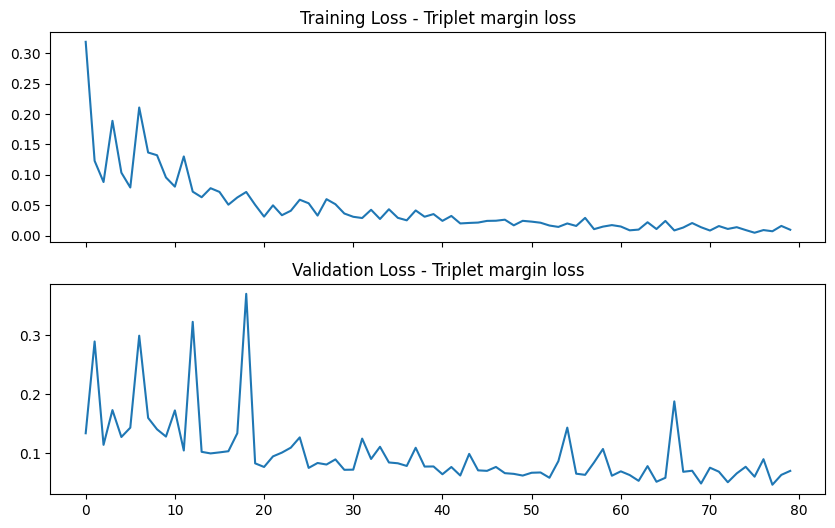

In [21]:
#Salvataggio plottato dei dati
if(model_weights == False):    
    fig, axes = plt.subplots(2, 1, sharex= True, figsize=(10, 6))
    axes[0].plot(training_loss)
    axes[0].set_title('Training Loss - Triplet margin loss')
    axes[1].plot(validation_loss)
    axes[1].set_title('Validation Loss - Triplet margin loss')
    plt.savefig('training_data_20000(biggan)-80-epochs.png')
    plt.show()

## Databse training embedded

In [22]:
#QUESTA E' LA FUNZIONE PER GENERARE I VETTORI DI ENCODING
# concatenating images name and relative encodings
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(dirFolder + i)
      A = np.expand_dims(A, 0)
      A = torch.from_numpy(A.astype(np.int32)) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [23]:


#QUI IL DATABASE COME CSV IN MODO TALE DA NON DOVER FARE QUESTA OPERAZIONE OGNI VOLTA
#OVVIAMENTE, SE DEVO FARE UN NUOVO TRAINING DEVO ANCHE RICREARE GLI ENCODINGS
if(model_weights == False):
    df_enc.to_csv('database_new.csv', index = False)

    df_enc = pd.read_csv('database_new.csv')
    df_enc.head()   

100%|████████████████████████████████████████████████████████████████████████████| 19000/19000 [03:33<00:00, 89.14it/s]


In [51]:
#QUI CREO IL DATABASE DI FEATURE VECTORS DEL TRAINING SET
df_enc = get_encoding_csv(model, df['Anchor'], DATA_DIR)

100%|████████████████████████████████████████████████████████████████████████████| 19000/19000 [03:38<00:00, 86.87it/s]


## Distances, Get image embeddings and searching in databse

In [52]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    #dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    return dist

In [53]:
# return the embedding of the image
def getImageEmbeddings(img, model):

    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img) / 255
    model.eval();

    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

## Adding 5 Latent Diffusion, 5 Taming Transformer

In [54]:
(df_enc.describe())

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,...,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000
mean,-0.542810,-1.575520,-0.019506,-2.165428,3.065102,-0.683643,1.923489,12.451963,0.861686,-1.125570,...,-1.186313,1.701711,3.275336,1.342871,0.753270,0.802875,-0.799774,-0.391264,-0.380628,0.837302
std,0.019973,0.026147,0.026618,0.011133,0.027200,0.002836,0.023615,0.111589,0.035872,0.022486,...,0.025284,0.012129,0.021018,0.029484,0.033997,0.002423,0.026374,0.028335,0.023268,0.009563
min,-0.620046,-1.672716,-0.063890,-2.229414,3.026274,-0.695835,1.882264,12.279205,0.804430,-1.208324,...,-1.271643,1.683533,3.240071,1.298441,0.700827,0.797252,-0.888568,-0.494642,-0.452386,0.799033
25%,-0.560186,-1.599325,-0.046782,-2.173331,3.037524,-0.685608,1.899164,12.337353,0.824762,-1.144953,...,-1.208766,1.689154,3.254811,1.312205,0.717581,0.801172,-0.823278,-0.417414,-0.401700,0.829356
50%,-0.546994,-1.586337,-0.015304,-2.164783,3.076531,-0.682621,1.932994,12.513896,0.870638,-1.130891,...,-1.197251,1.706341,3.279932,1.352881,0.765754,0.801915,-0.810826,-0.398621,-0.389929,0.838301
75%,-0.522442,-1.548072,0.004436,-2.155414,3.087053,-0.681562,1.945602,12.545722,0.892940,-1.102669,...,-1.159949,1.713042,3.293870,1.369392,0.784301,0.804679,-0.772270,-0.361661,-0.356339,0.846342
max,-0.511632,-1.537562,0.084742,-2.147961,3.175776,-0.676558,2.013862,12.904867,1.009398,-1.093386,...,-1.150510,1.746411,3.369182,1.447562,0.875054,0.811540,-0.761541,-0.346293,-0.347416,0.855027


In [55]:
current_dir = os.getcwd()
fake_image_folder_latent = os.path.join(current_dir, "dataset", "latent_diffusion", "latentdiff-t2i_spectrum")
fake_image_folder_taming = os.path.join(current_dir, "dataset", "taming_transformer", "tt-ffhq_spectrum") 

In [56]:
# Ottieniamo i percorsi relativi per le immagini fake+
fake_image_paths_latent = []
for root, dirs, files in os.walk(fake_image_folder_latent):
    for filename in files:
        if filename.endswith(".jpg"):
            fake_image_paths_latent.append(os.path.relpath(os.path.join(root, filename)))

# Ottieniamo i percorsi relativi per le immagini fake+
fake_image_paths_taming = []
for root, dirs, files in os.walk(fake_image_folder_taming):
    for filename in files:
        if filename.endswith(".jpg"):
            fake_image_paths_taming.append(os.path.relpath(os.path.join(root, filename)))

print(len(fake_image_paths_latent))
print(len(fake_image_paths_taming))

num_random_elemnt = 5

taming_random = random.sample(fake_image_paths_taming,num_random_elemnt)
latent_random = random.sample(fake_image_paths_latent,num_random_elemnt)

print(taming_random)
print(latent_random)


embeddings_new_taming_latent_imgs = []

for i in range(num_random_elemnt):
    taming_random_img = io.imread(taming_random[i])
    latent_random_img = io.imread(latent_random[i])
    taming_random_img_embed = getImageEmbeddings(taming_random_img, model)[0,:]
    latent_random_img_embed = getImageEmbeddings(latent_random_img, model)[0,:]
    embeddings_new_taming_latent_imgs.append(taming_random_img_embed)
    embeddings_new_taming_latent_imgs.append(latent_random_img_embed)


print(len(embeddings_new_taming_latent_imgs[0]))
    


10000
50000
['dataset\\taming_transformer\\tt-ffhq_spectrum\\img014654.jpg', 'dataset\\taming_transformer\\tt-ffhq_spectrum\\img001460.jpg', 'dataset\\taming_transformer\\tt-ffhq_spectrum\\img037732.jpg', 'dataset\\taming_transformer\\tt-ffhq_spectrum\\img023665.jpg', 'dataset\\taming_transformer\\tt-ffhq_spectrum\\img021060.jpg']
['dataset\\latent_diffusion\\latentdiff-t2i_spectrum\\img008385.jpg', 'dataset\\latent_diffusion\\latentdiff-t2i_spectrum\\img007333.jpg', 'dataset\\latent_diffusion\\latentdiff-t2i_spectrum\\img006790.jpg', 'dataset\\latent_diffusion\\latentdiff-t2i_spectrum\\img009864.jpg', 'dataset\\latent_diffusion\\latentdiff-t2i_spectrum\\img007202.jpg']
512


In [118]:
df_latent_taming_new = pd.DataFrame(embeddings_new_taming_latent_imgs)
df_latent_taming_new.describe()

df_enc_plus_latent_taming = pd.concat([df_enc, df_latent_taming_new], ignore_index=True)
print(len(df_enc_plus_latent_taming))
(df_enc_plus_latent_taming.describe())

19010


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,...,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000,19010.000000
mean,-0.542805,-1.575513,-0.019512,-2.165426,3.065095,-0.683642,1.923481,12.451929,0.861679,-1.125565,...,-1.186306,1.701707,3.275328,1.342864,0.753261,0.802874,-0.799767,-0.391257,-0.380621,0.837304
std,0.019972,0.026146,0.026615,0.011133,0.027199,0.002836,0.023613,0.111583,0.035869,0.022485,...,0.025282,0.012128,0.021017,0.029482,0.033994,0.002423,0.026372,0.028333,0.023267,0.009562
min,-0.620046,-1.672716,-0.063890,-2.229414,3.026274,-0.695835,1.882264,12.279205,0.804430,-1.208324,...,-1.271643,1.683533,3.240071,1.298441,0.700827,0.797252,-0.888568,-0.494642,-0.452386,0.799033
25%,-0.560185,-1.599325,-0.046781,-2.173327,3.037526,-0.685607,1.899164,12.337356,0.824766,-1.144951,...,-1.208765,1.689154,3.254811,1.312206,0.717582,0.801171,-0.823276,-0.417413,-0.401699,0.829358
50%,-0.546960,-1.586299,-0.015370,-2.164765,3.076513,-0.682618,1.932865,12.513860,0.870625,-1.130830,...,-1.197246,1.706299,3.279881,1.352823,0.765749,0.801914,-0.810814,-0.398554,-0.389909,0.838307
75%,-0.522445,-1.548077,0.004434,-2.155414,3.087051,-0.681562,1.945599,12.545720,0.892940,-1.102671,...,-1.159950,1.713042,3.293867,1.369385,0.784300,0.804676,-0.772273,-0.361661,-0.356340,0.846341
max,-0.511632,-1.537562,0.084742,-2.147961,3.175776,-0.676558,2.013862,12.904867,1.009398,-1.093386,...,-1.150510,1.746411,3.369182,1.447562,0.875054,0.811540,-0.761541,-0.346293,-0.347416,0.855027


In [105]:
# return the closest image in the database given an img_enc
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database['Anchor']

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)
    
    closest_idx = np.argsort(distance)

    return database['Anchor'][closest_idx[0]]

# Defining test list

In [106]:
df_enc_plus_latent_taming.to_csv("df_new_enc_database.csv", index = False)

In [107]:
#DataTestReal = 'test_set_taming_transformer.csv'
#test_df = pd.DataFrame(combined_images, columns = [''])

In [112]:
test = "test_set_latentDiff.csv"
test_latent = pd.read_csv(test, header = None)

## Testing

In [113]:
database = df_enc_plus_latent_taming
(database.describe())
y_true = ['fake'] * 500 + ['real'] * 500
y_pred = []

In [114]:
def test_images(test_df, start_index, end_index, database, model):
    for index, row in tqdm(test_df.iloc[start_index:end_index].iterrows(), total=end_index-start_index):
        img_name = row[0] # Accesso diretto alla prima (e unica) colonna

        # Verifica se il nome del file è valido
        if pd.isnull(img_name) or not os.path.isfile(img_name):
            print(f"Invalid image file path at index {index}: {img_name}")
            y_pred.append("error")
            continue
        
        # Leggi e processa l'immagine
        img = io.imread(img_name)

        # Ottieni gli embeddings dell'immagine
        img_enc = getImageEmbeddings(img, model)

        # Cerca nel database
        closestLabel = searchInDatabase(img_enc, database)
       
        # Aggiungi la predizione alla lista
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

In [115]:
test_images(test_latent, 0, 1000, database, model)

  2%|█▉                                                                              | 24/1000 [00:06<04:29,  3.62it/s]


TypeError: argument of type 'float' is not iterable

In [96]:
#Creo i vettori di ground truth
y_true = np.array(['fake'] * 500)
print(y_true.shape)

temp = np.array(['real'] * 500)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

#Calcolo la matrice di confusione
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])

(500,)
(500,)
(1000,)


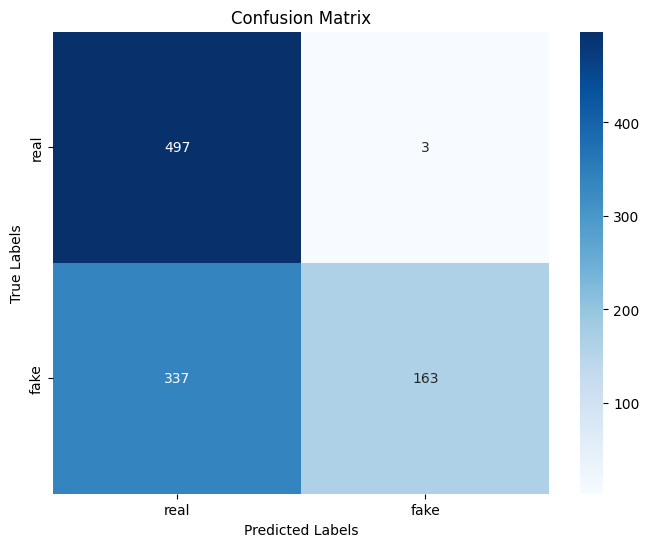

In [97]:
#Estraggo dalla matrice di confusione i True Negative, False Positive, False Negative, True Positive
TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=["real", "fake"]).ravel()

# Plotto la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
# Salvo l'immagine
plt.savefig('confusion_matrix_1000(latentDiffusion-coco)_new_database.png')
plt.show()

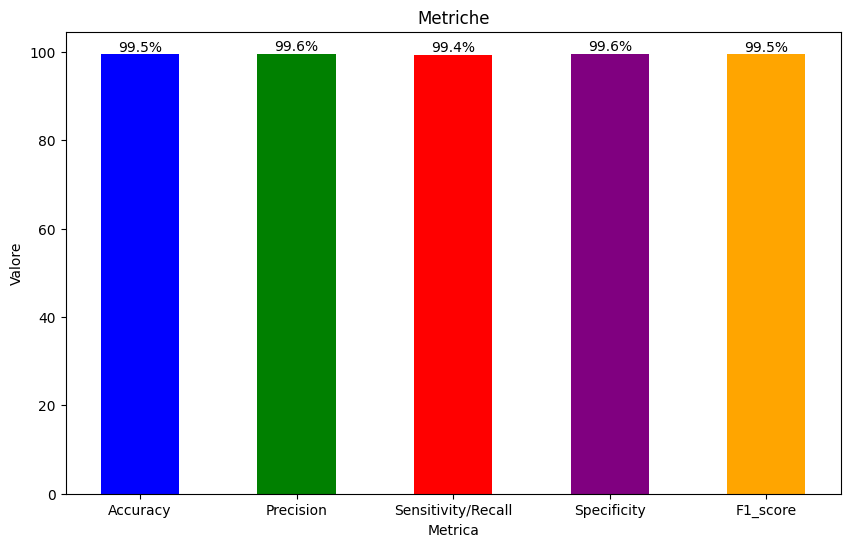

In [67]:
#Calcolo alcune metriche per vedere come si comporta
accuracy = round((TP + TN) /(TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
sensitivy_recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
F1_score = round((2* precision * sensitivy_recall) / (precision + sensitivy_recall), 2)

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Sensitivity/Recall": sensitivy_recall,
    "Specificity": specificity,
    "F1_score": F1_score
}

# Nomi delle metriche
labels = list(metrics.keys())

# Valori delle metriche
values = list(metrics.values())

# Creazione dell'istogramma
plt.figure(figsize=(10,6))
plt.bar(labels, values, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)

# Aggiunta delle etichette
for i in range(len(labels)):
    plt.text(i, values[i], f'{values[i]}%', ha = 'center', va = 'bottom')

# Titoli e etichette degli assi
plt.title('Metriche')
plt.xlabel('Metrica')
plt.ylabel('Valore')

plt.savefig('Metrics_with_latentDiff-coco_new_database.png')

# Mostra l'istogramma
plt.show()

In [68]:
print({"Accuracy":accuracy,"Precision":precision,"Sensitivity_recall":sensitivy_recall, "Specificity": specificity, "F1_score":F1_score})

{'Accuracy': 99.5, 'Precision': 99.6, 'Sensitivity_recall': 99.4, 'Specificity': 99.6, 'F1_score': 99.5}
